In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

import keras
from tqdm import tqdm
import os

def printmd(string):
    display(Markdown(string))

In [2]:
image_dir = Path('C:/Users/User/project_final/colored_images')

filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [3]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

image_df = image_df.sample(frac=1).reset_index(drop = True)

image_df.head(3)

,Filepath,Label
0,C:\Users\User\project_final\colored_images\Mod...,Moderate
1,C:\Users\User\project_final\colored_images\No_...,No_DR
2,C:\Users\User\project_final\colored_images\Mod...,Moderate


In [5]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths, labels], axis=1)
image_df = image_df.sample(frac=1).reset_index(drop=True)

In [4]:
def apply_clahe(image_dir):
    img = cv2.imread(image_dir)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl1 = clahe.apply(img)
    return cl1

In [5]:
import cv2
# Apply CLAHE to a subset of images for display
sample_images = image_df.sample(12)
enhanced_images = [apply_clahe(img_path) for img_path in sample_images['Filepath']]

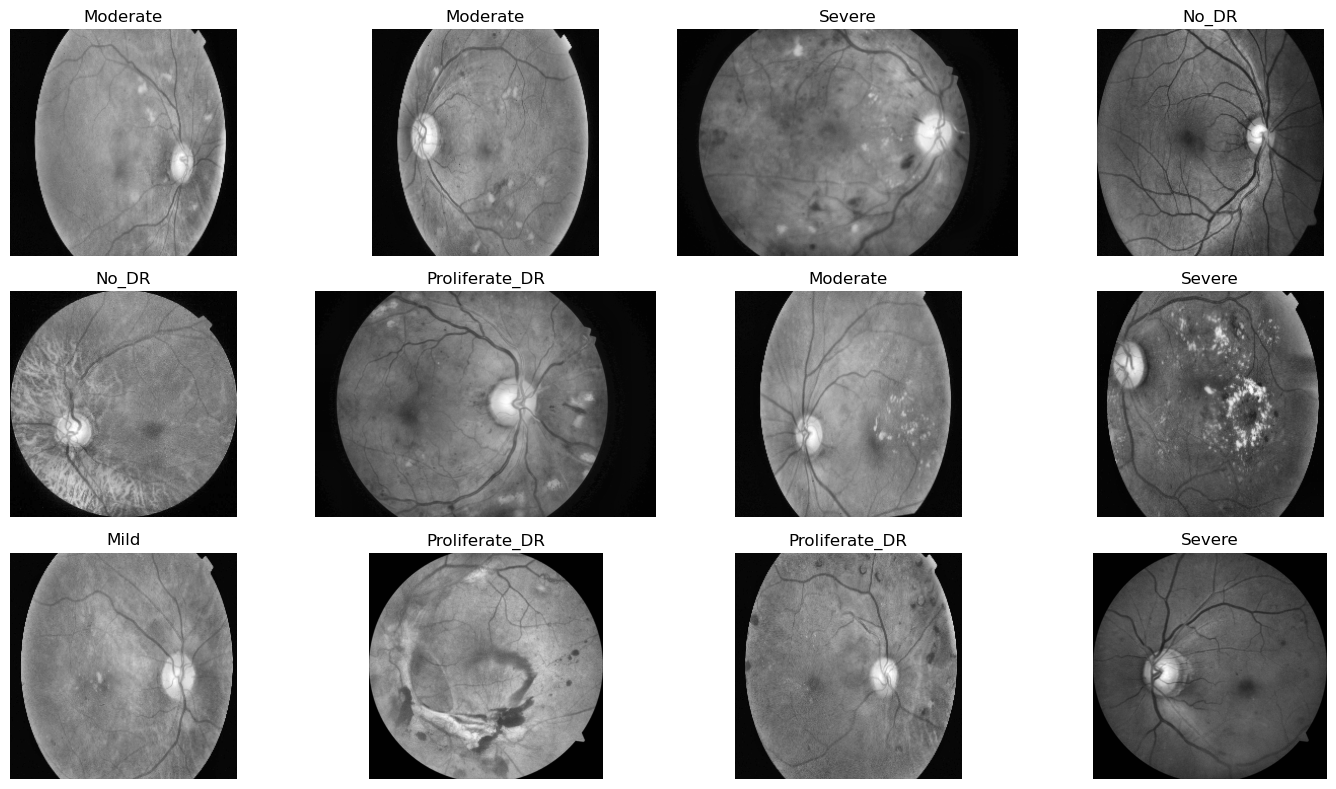

In [6]:
# Display enhanced images
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(enhanced_images[i], cmap='gray')
    ax.set_title(sample_images['Label'].values[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Apply CLAHE to all images and save them in a new directory
enhanced_image_dir = Path('C:/Users/User/project 01/enhanced_images')
enhanced_image_dir.mkdir(parents=True, exist_ok=True)

for idx, row in image_df.iterrows():
    enhanced_img = apply_clahe(row['Filepath'])
    enhanced_img_path = enhanced_image_dir / Path(row['Filepath']).relative_to(image_dir)
    enhanced_img_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(enhanced_img_path), enhanced_img)

print("CLAHE applied to all images and saved in 'enhanced_images' directory.")

In [7]:
def create_gen():
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [8]:
def get_model(model):
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [9]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [10]:
models = {
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "DenseNet121": {"model":tf.keras.applications.ResNet101, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.MobileNet, "perf":0}
}

train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

Found 3622 validated image filenames belonging to 5 classes.
Found 402 validated image filenames belonging to 5 classes.
Found 448 validated image filenames belonging to 5 classes.




In [11]:
for name, model in models.items():

    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)

    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


114/114 ━━━━━━━━━━━━━━━━━━━━ 439s 3s/step - accuracy: 0.6074 - loss: 0.9904 - val_accuracy: 0.8060 - val_loss: 0.6148
DenseNet169          trained in 441.0 sec
114/114 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.6138 - loss: 1.0061 - val_accuracy: 0.7562 - val_loss: 0.6509
MobileNet            trained in 164.69 sec
114/114 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - accuracy: 0.4607 - loss: 1.3812 - val_accuracy: 0.5398 - val_loss: 1.2026
DenseNet121          trained in 364.85 sec
114/114 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.6130 - loss: 1.0116 - val_accuracy: 0.7562 - val_loss: 0.6792
InceptionV3          trained in 165.96 sec


In [12]:
models_result = []

for name, v in models.items():
    models_result.append([ name,
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,train_accuracy,val_accuracy,Training time (sec)
0,DenseNet169,0.6814,0.8060,441.00
1,MobileNet,0.6803,0.7562,164.69
2,InceptionV3,0.6778,0.7562,165.96
3,DenseNet121,0.5083,0.5398,364.85


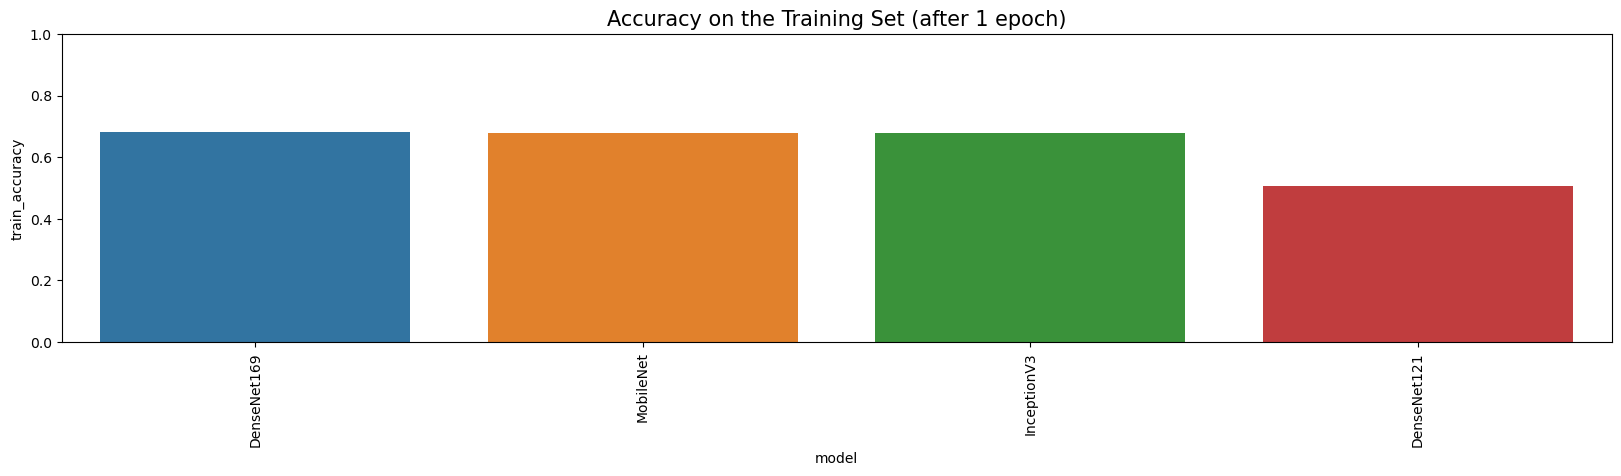

In [13]:
plt.figure(figsize = (20,4))
sns.barplot(x = 'model', y = 'train_accuracy', data = df_results)
plt.title('Accuracy on the Training Set (after 1 epoch)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

In [14]:
pretrained_model = tf.keras.applications.DenseNet169(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False
pretrained_model.summary()

Model: "densenet169"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 12,642,880 (48.23 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,642,880 (48.23 MB)

In [15]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy','AUC']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 333s 3s/step - AUC: 0.8536 - accuracy: 0.6004 - loss: 1.0373 - val_AUC: 0.9497 - val_accuracy: 0.7562 - val_loss: 0.6440
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - AUC: 0.9507 - accuracy: 0.7654 - loss: 0.6264 - val_AUC: 0.9549 - val_accuracy: 0.8184 - val_loss: 0.5921
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - AUC: 0.9607 - accuracy: 0.7959 - loss: 0.5553 - val_AUC: 0.9630 - val_accuracy: 0.7985 - val_loss: 0.5401
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - AUC: 0.9651 - accuracy: 0.7927 - loss: 0.5237 - val_AUC: 0.9607 - val_accuracy: 0.8010 - val_loss: 0.5552
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - AUC: 0.9710 - accuracy: 0.8199 - loss: 0.4713 - val_AUC: 0.9658 - val_accuracy: 0.8333 - val_loss: 0.5129
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - AUC: 0.9703 - accuracy: 0.8104 - loss: 0.4783 - val_AUC: 0.9649 - val_accuracy: 0.8284 - val_loss: 0.5232
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━

In [16]:
model.save('C:/Users/User/project 01/models/DenseNet169_model.h5')

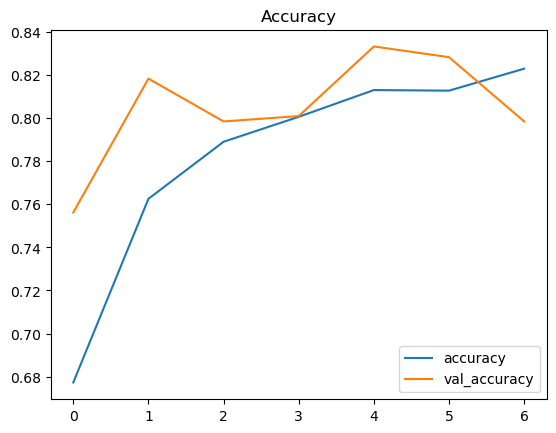

In [17]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

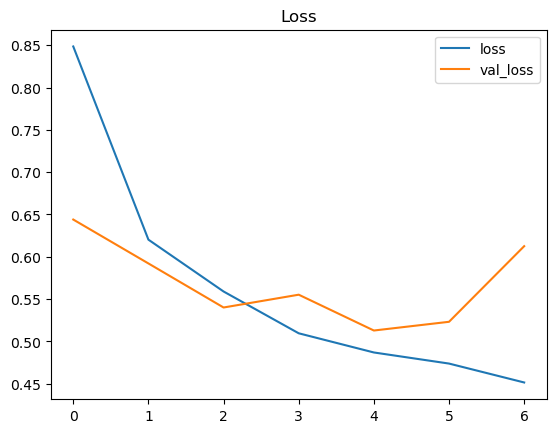

In [18]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [19]:
results = model.evaluate(test_images, verbose=0)

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [20]:
printmd("Test Loss: {:.5f}".format(results[0]))
printmd("Accuracy on the test set: {:.2f}%".format(results[1] * 100))

Test Loss: 0.47799

Accuracy on the test set: 83.71%

In [21]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step


In [22]:
from sklearn.metrics import classification_report

y_true = test_images.classes 
y_pred = model.predict(test_images)  

y_pred = y_pred.argmax(axis=-1)

class_labels = list(test_images.class_indices.keys())

report = classification_report(y_true, y_pred, target_names=class_labels)

print(report)

14/14 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step
                precision    recall  f1-score   support

          Mild       0.80      0.44      0.57        45
      Moderate       0.73      0.97      0.84       105
         No_DR       0.96      0.97      0.96       197
Proliferate_DR       0.82      0.33      0.47        43
        Severe       0.71      0.81      0.76        58

      accuracy                           0.84       448
     macro avg       0.80      0.71      0.72       448
  weighted avg       0.84      0.84      0.82       448



1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted class: No_dr
Confidence: 0.9603630304336548


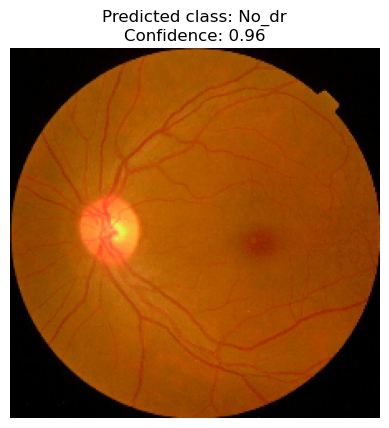

In [3]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model("C:/Users/User/project_final/models/DenseNet169.h5") 

model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

# Load and preprocess the input image
image_path = "C:/Users/User/project_final/colored_images/No_DR/00cc2b75cddd.png"  
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
image = cv2.resize(image, (224, 224))  # Resize to match the model's input size
image = image / 255.0  # Normalize pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # Expand dimensions for batch size

# Use the model to make predictions
predictions = model.predict(image)

# Interpret the predictions
class_labels = ["Mild", "Moderate", "No_dr", "Proliferate_dr", "Severe"] 
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}")

plt.imshow(image[0])
plt.title(f"Predicted class: {predicted_class}\nConfidence: {confidence:.2f}")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted class: Moderate
Confidence: 0.831192135810852


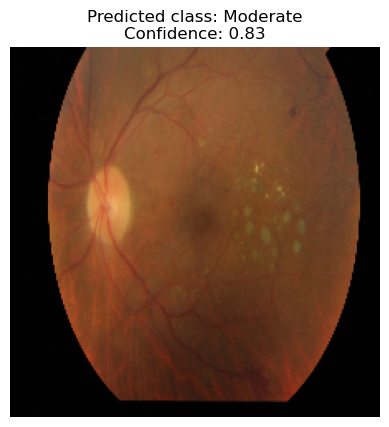

In [28]:
import cv2
import numpy as np
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("C:/Users/User/project 01/models/DenseNet169.h5") 

model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
# Load and preprocess the input image
image_path = "C:/Users/User/project 01/colored_images/Mild/1d674e2e32e0.png"  
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
image = cv2.resize(image, (224, 224))  # Resize to match the model's input size
image = image / 255.0  # Normalize pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # Expand dimensions for batch size

# Use the model to make predictions
predictions = model.predict(image)

# Interpret the predictions
class_labels = ["Mild", "Moderate", "No_dr", "Proliferate_dr", "Severe"]  
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}")

plt.imshow(image[0])
plt.title(f"Predicted class: {predicted_class}\nConfidence: {confidence:.2f}")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted class: Proliferate_dr
Confidence: 0.7652944922447205


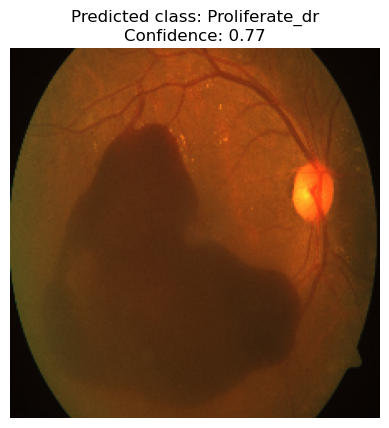

In [29]:
import cv2
import numpy as np
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("C:/Users/User/project 01/models/DenseNet169.h5")  

model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
# Load and preprocess the input image
image_path = "C:/Users/User/project 01/colored_images/Proliferate_DR/4bd941611343.png"  
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
image = cv2.resize(image, (224, 224))  # Resize to match the model's input size
image = image / 255.0  # Normalize pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # Expand dimensions for batch size

# Use the model to make predictions
predictions = model.predict(image)

# Interpret the predictions
class_labels = ["Mild", "Moderate", "No_dr", "Proliferate_dr", "Severe"]  
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}")

plt.imshow(image[0])
plt.title(f"Predicted class: {predicted_class}\nConfidence: {confidence:.2f}")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted class: Severe
Confidence: 0.7386432886123657


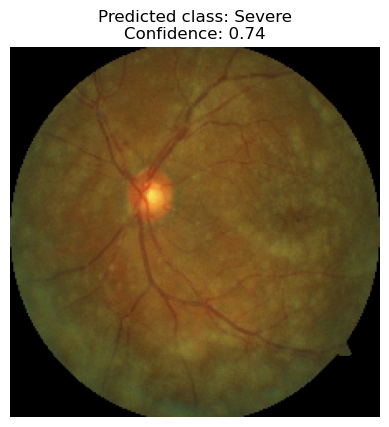

In [4]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model("C:/Users/User/project 01/models/DenseNet169.h5") 

model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
# Load and preprocess the input image
image_path = "C:/Users/User/project 01/colored_images/Severe/374.png"  
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
image = cv2.resize(image, (224, 224))  # Resize to match the model's input size
image = image / 255.0  # Normalize pixel values to [0, 1]
image = np.expand_dims(image, axis=0)  # Expand dimensions for batch size

# Use the model to make predictions
predictions = model.predict(image)

# Interpret the predictions
class_labels = ["Mild", "Moderate", "No_dr", "Proliferate_dr", "Severe"]  
predicted_class_index = np.argmax(predictions)
predicted_class = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence}")

plt.imshow(image[0])
plt.title(f"Predicted class: {predicted_class}\nConfidence: {confidence:.2f}")
plt.axis("off")
plt.show()